In [1]:
# 필요 패키지들을 호출
from collections import defaultdict
from IPython.display import clear_output
import numpy as np
import random
import gym

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Cliff walking 환경 정의
env = gym.make('CliffWalking-v0')

/home/hshwang/anaconda3/envs/RL_scratch/lib/python3.8/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:
# Cliff walking에 대한 설명문
print(env.__doc__)


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.

    Adapted from Example 6.6 (page 145) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://people.inf.elte.hu/lorincz/Files/RL_2006/SuttonBook.pdf
    
    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward 
    and a reset to the start. An episode terminates when the agent reaches the goal.
    


In [4]:
# 현재 state의 Cliff walking 환경을 시각화합니다.
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [5]:
# gym 환경의 기본 기능을 익혀봅시다
# env.reset() : 환경 개시
# env.step(action): 환경 행동부여
# env.render(): 환경 시각화 -> 이미지 혹은 텍스트(Gridworld)
state = env.reset()
print(state)

36


In [6]:
env.action_space.n

4

In [7]:
# 에이전트가 행동을 하는 것을 모사
# 출력값: 다음상태, 보상, 종료여부, 정보 
# 정보는 환경과 관련된 부수적인 요소들을 딕셔너리 형태로 포함 -> 생략해도 무방
next_state,reward,done,infs = env.step(env.action_space.sample())

In [8]:
print(next_state, reward, done,infs)

24 -1 False {'prob': 1.0}


In [9]:
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T



In [10]:
# Q-learning 에이전트 작성
class Qlearning:
    def __init__(self,possible_actions,alpha=0.25,epsilon=0.2,gamma=0.99):
        '''
        초기 입력인자
            possible_actions: State에서 에이전트가 취할수 있는 행동, (defaultdict s)
            alpha: 학습률
            epsilon: Exploration 확률 <- 학습초기: 높은확률, 학습후기: 낮은확률
            gamma: 할인율
        Class의 속성
            Q-함수 정의 -> self.def_qvalue
            Q-함수 출력 -> self.get_qvalue
            Q-함수 업데이트 -> self.update_qvalue
            행동 추출 
                -> self.epsilon_action
                -> self.argmax_action
        '''
        self.possible_actions=possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.q_value = defaultdict(lambda: defaultdict(lambda: 0))
        
    def def_qvalue(self,state,action,q_value):
        '''
        Q-함수값 정의, Q(s,a) <- q_value
            입력: state, action, q_value
            출력: X
        '''
        self.q_value[state][action] = q_value
    
    def get_qvalue(self,state,action):
        '''
        Q-함수값 출력
            입력: state, action
            출력: Q(s,a)
        '''
        return self.q_value[state][action]
    
    def max_Q(self,state):
        '''
        max_{a}Q(s',a) 구하기
            입력: state
            출력: max_{a}Q(s,a)
        '''
        possible_actions = self.possible_actions(state)
        Qs = []
        for possible_action in possible_actions:
            Qs.append(self.get_qvalue(state,possible_action))
        Qs = max(Qs)
        return Qs
    
    def update(self,state,action,reward,next_state):
        '''
        Q-learning 업데이트식, Q(s,a) <- Q(s,a) + alpha*(reward+gamma*max(Q(s',a'))-Q(s,a))
            입력: state, action, reward, next_state
            출력: X
        '''
        next_q = self.max_Q(next_state)
        # 업데이트식
        rhs = (1-self.alpha)*self.get_qvalue(state,action)+self.alpha*(reward+self.gamma*next_q) 
        self.def_qvalue(state,action,rhs)
    
    def max_action(self,state):
        '''
        Q-함수값에 전적으로 의존한 최적의 action -> argmax_{a}Q(s,a)
            입력: state
            출력: action
        '''
        Qmax = self.max_Q(state)
        possible_actions = self.possible_actions(state)
        action = np.random.choice(possible_actions)
        for possible_action in possible_actions:
            Qvalue = self.get_qvalue(state,possible_action)
            if Qvalue >= Qmax:
                Qmax = Qvalue
                action = possible_action
        return action
    
    def epsilon_action(self,state):
        '''
        Epsilon-greedy 방식에 근거한 행동추출
        -> 임의로 정의한 확률 p와 epsilon을 비교, 작은경우: Exploration, 큰 경우: Exploitation
            입력: state
            출력: 현재 state에 적절한 action
        '''
        possible_actions = self.possible_actions(state)
        p = np.random.uniform(0,1)
        if p <= self.epsilon: # Exploration
            best_action = np.random.choice(possible_actions)
        else: # Exploitation
            best_action = self.max_action(state)
        return best_action

In [11]:
# SARSA 에이전트 작성
class SARSA(Qlearning):
    '''
    SARSA 역시 Qlearning과 동일,
    단, 행동추출의 방식의 차이만 반영
    '''
    
    def update(self,state,action,reward,next_state):
        '''
        SARSA 업데이트식, Q(s,a) <- Q(s,a) + alpha*(reward+gamma*Q(s',a')-Q(s,a))
        (a' <- epsilon-greedy 정책)
            입력: state, action, reward, next_state
            출력: X
        '''
        next_action = self.epsilon_action(next_state)
        next_q = self.get_qvalue(next_state,next_action)
        rhs = (1-self.alpha)*self.get_qvalue(state,action)+self.alpha*(reward+self.gamma*next_q) # 업데이트식
        self.def_qvalue(state,action,rhs)

In [12]:
def play_and_train(env, agent, t_max=10**4):
    '''
    에이전트 학습 코드(gym style)
    입력인자
        env: 환경 -> Cliff walking
        agent: 에이전트 -> Q-agent, SARSA_agent
        t_max: 최대 시점 -> 강제 에피소드 종료시점 설정
    출력인자
        total_reward: 최종보상(할인 X)
    '''
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        a = agent.epsilon_action(s)
        
        next_s, r, done, _ = env.step(a)
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

In [13]:
n_actions = env.action_space.n # 각 행동에는 4개의 행동이 가능 - 상,하,좌,우

Q_agent = Qlearning(lambda s: range(n_actions))
SARSA_agent = SARSA(lambda s: range(n_actions))

In [14]:
def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

1900번째 에피소드 결과
SARSA 보상평균(100번 에피소드) = -27.99
Q-Learning 보상평균(100번 에피소드) = -100.27


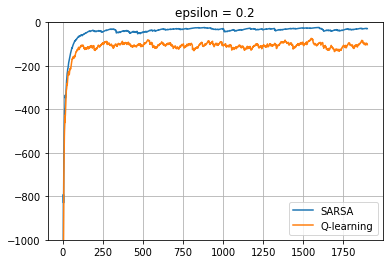

In [15]:
rewards_sarsa, rewards_ql = [], []
for i in range(2000):
    rewards_sarsa.append(play_and_train(env, SARSA_agent))
    rewards_ql.append(play_and_train(env, Q_agent))

    if i % 100 == 0:
        clear_output(True)
        print(f'{i}번째 에피소드 결과')
        print(f'SARSA 보상평균(100번 에피소드) = {np.mean(rewards_sarsa[-100:])}')
        print(f'Q-Learning 보상평균(100번 에피소드) = {np.mean(rewards_ql[-100:])}')

        
        plt.title(f"epsilon = {Q_agent.epsilon}")
        plt.plot(moving_average(rewards_sarsa),label='SARSA')
        plt.plot(moving_average(rewards_ql),label='Q-learning')
        
        plt.grid()
        plt.legend()
        plt.ylim(-1000, 0)
        plt.show()

In [16]:
def drawing_policy(agent):
    '''
    각 상태에서 행동이 무엇이었는지 시각화하여 관찰
    입력
        agent: SARSA, Q-learning
    출력
        Text plot
        반환값 X
    '''
    action_character = '>^V<'
    num_columns = 12
    num_rows = 4
    for row in range(num_rows):
        for column in range(num_columns):
            state = row*num_columns+column
            a = agent.max_action(state)
            if state == 36:
                print(f'S ',end=' ')
            elif state > 36 and state < 47:
                print(f'X ',end=' ')
            elif state == 47:
                print(f'F')
            elif column < num_columns-1:
                print(f'{action_character[a]} ', end=' ')
            elif column == num_columns-1:
                print(f'{action_character[a]}') 

In [17]:
drawing_policy(SARSA_agent)

^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  V
^  >  >  >  >  >  >  >  >  >  ^  V
>  >  >  >  >  >  >  >  >  >  ^  V
S  X  X  X  X  X  X  X  X  X  X  F


In [18]:
drawing_policy(Q_agent)

V  ^  ^  ^  V  V  ^  ^  ^  ^  V  V
V  ^  V  V  V  V  V  V  V  V  V  V
^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  V
S  X  X  X  X  X  X  X  X  X  X  F


# 심화 - Eligibility trace
---
$G_{t}^{\lambda}$를 이용한 SARSA, Q-learning알고리즘 구현

목적: TD(0) vs MC 어느정도의 Temporal difference를 사용해야 최적의 결과가 나오는가?


## Q-learning with Eligibility trace
---

Step 1. 상태 $S$, 행동 $A$, Eligibility trace $E(s,a)$ 초기화

Step 2. $A$ 행동개시 -> $R$, $S'$ 

Step 3. 다음행동 $A'$ <- $max_{a}Q(s,a)$ 방식

Step 4. TD-error 계산 ${\delta} \leftarrow R+{\gamma}Q(S',A')-Q(S,A)$ 

Step 5. $E(S,A) \leftarrow E(S,A)+1$

Step 6. Q업데이트 $Q(S,A) \leftarrow Q(S,A) + {\alpha}{\delta}E(S,A)$

Step 7. $E(S,A) \leftarrow \gamma \lambda E(S,A)$

Step 8. $S \leftarrow S'$, $A \leftarrow A'$

Step 8. 에피소드 종료까지 Step 2~8 반복

In [19]:
class Qlearning_ET():
    def __init__(self,possible_actions,alpha=0.25,epsilon=0.2,gamma=0.99,lamb=0.75):
        '''
        초기 입력인자
            possible_actions: State에서 에이전트가 취할수 있는 행동, (defaultdict s)
            alpha: 학습률
            epsilon: Exploration 확률 <- 학습초기: 높은확률, 학습후기: 낮은확률
            gamma: 할인율
            lamb: Temporal-Difference 가중치, 0: TD(0), 1: Monte-Carlo
        Class의 속성
            Q-함수 정의 -> self.def_qvalue
            Q-함수 출력 -> self.get_qvalue
            Q-함수 업데이트 -> self.update_qvalue
            행동 추출 
                -> self.epsilon_action
                -> self.argmax_action
            Eligibility 정의 -> self.def_Etrace
            Eligibility 출력 -> self.get_Etrace
            Eligibility 업데이트 -> self.update_Etrace
        '''
        self.possible_actions=possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.lamb = lamb
        self.q_value = defaultdict(lambda: defaultdict(lambda: 0))
        self.E_trace = defaultdict(lambda: defaultdict(lambda: 0))
        
    def def_qvalue(self,state,action,q_value):
        '''
        Q-함수값 정의, Q(s,a) <- q_value
            입력: state, action, q_value
            출력: X
        '''
        self.q_value[state][action] = q_value
    
    def def_Etrace(self,state,action,value):
        '''
        Eligibility trace 정의, E(s,a) <- value
            입력: state,action,value
            출력: X
        '''
        self.E_trace[state][action] = value
    
    def get_qvalue(self,state,action):
        '''
        Q-함수값 출력
            입력: state, action
            출력: Q(s,a)
        '''
        return self.q_value[state][action]
    
    def get_Etrace(self,state,action):
        '''
        Eligibility trace 출력
            입력: state, action
            출력: E(s,a)
        '''
        return self.E_trace[state][action]
    
    def max_Q(self,state):
        '''
        max_{a}Q(s',a) 구하기
            입력: state
            출력: max_{a}Q(s,a)
        '''
        possible_actions = self.possible_actions(state)
        Qs = []
        for possible_action in possible_actions:
            Qs.append(self.get_qvalue(state,possible_action))
        Qs = max(Qs)
        return Qs
    
    def update(self,state,action,reward,next_state):
        '''
        Q-learning 업데이트식, 
        delta <- reward+gamma*maxQ(s',a')-Q(s,a)
        E(s,a) <- E(s,a)+1
        Q(s,a) <- Q(s,a) + alpha*E(s,a)
        E(s,a) <- gamma*lambda*E(s,a)
            입력: state, action, reward, next_state
            출력: X
        '''
        next_q = self.max_Q(next_state)
        # 업데이트식
        delta = reward+self.gamma*next_q-self.get_qvalue(state,action)
        self.def_Etrace(state,action,self.get_Etrace(state,action)+1)
        self.def_qvalue(state,action,self.alpha*delta*self.get_Etrace(state,action))
        self.def_Etrace(state,action,self.alpha*self.gamma*self.get_Etrace(state,action))
    
    def max_action(self,state):
        '''
        Q-함수값에 전적으로 의존한 최적의 action -> argmax_{a}Q(s,a)
            입력: state
            출력: action
        '''
        Qmax = self.max_Q(state)
        possible_actions = self.possible_actions(state)
        action = np.random.choice(possible_actions)
        for possible_action in possible_actions:
            Qvalue = self.get_qvalue(state,possible_action)
            if Qvalue >= Qmax:
                Qmax = Qvalue
                action = possible_action
        return action
    
    def epsilon_action(self,state):
        '''
        Epsilon-greedy 방식에 근거한 행동추출
        -> 임의로 정의한 확률 p와 epsilon을 비교, 작은경우: Exploration, 큰 경우: Exploitation
            입력: state
            출력: 현재 state에 적절한 action
        '''
        possible_actions = self.possible_actions(state)
        p = np.random.uniform(0,1)
        if p <= self.epsilon: # Exploration
            best_action = np.random.choice(possible_actions)
        else: # Exploitation
            best_action = self.max_action(state)
        return best_action

## SARSA - with Eligibility trace
---

Step 1. 상태 $S$, 행동 $A$, Eligibility trace $E(s,a)$ 초기화

Step 2. $A$ 행동개시  $\rightarrow  R$, $S'$ 

Step 3. 다음행동 $A'$ $\leftarrow {\epsilon}-greedy$ 방식

Step 4. TD-error 계산 ${\delta} \leftarrow R+{\gamma}Q(S',A')-Q(S,A)$ 

Step 5. $E(S,A) \leftarrow E(S,A)+1$

Step 6. Q업데이트 $Q(S,A) \leftarrow Q(S,A) + {\alpha}{\delta}E(S,A)$

Step 7. $E(S,A) \leftarrow \gamma \lambda E(S,A)$

Step 8. $S \leftarrow S'$, $A \leftarrow A'$

Step 8. 에피소드 종료까지 Step 2~8 반복



In [20]:
class SARSA_ET(Qlearning_ET):
    '''
    SARSA_eligibility trace 역시 Qlearning_eligibility trace와 동일,
    단, 행동추출의 방식의 차이만 반영
    '''
    def update(self,state,action,reward,next_state):
        '''
        Q-learning 업데이트식, 
        a' <- epsilon greedy
        delta <- reward+gamma*Q(s',a')-Q(s,a)
        E(s,a) <- E(s,a)+1
        Q(s,a) <- Q(s,a) + alpha*E(s,a)*delta
        E(s,a) <- gamma*lambda*E(s,a)
            입력: state, action, reward, next_state
            출력: X
        '''
        next_action = self.epsilon_action(next_state)
        next_q = self.get_qvalue(next_state,next_action)
        # 업데이트식
        delta = reward+self.gamma*next_q-self.get_qvalue(state,action)
        self.def_Etrace(state,action,self.get_Etrace(state,action)+1)
        self.def_qvalue(state,action,self.alpha*delta)
        self.def_Etrace(state,action,self.alpha*self.gamma*self.get_Etrace(state,action))

In [23]:
Qet_agent = Qlearning_ET(lambda s: range(n_actions),lamb=0.1)
SARSAet_agent = SARSA_ET(lambda s: range(n_actions),lamb=0.1)

1900번째 에피소드 결과
SARSA_Etrace 보상평균(100번 에피소드) = -697.85
Q-Learning_Etrace 보상평균(100번 에피소드) = -114.45


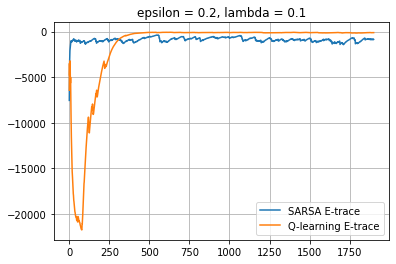

In [24]:
rewards_sarsaet, rewards_qlet = [], []
for i in range(2000):
    rewards_sarsaet.append(play_and_train(env, SARSAet_agent))
    rewards_qlet.append(play_and_train(env, Qet_agent))

    if i % 100 == 0:
        clear_output(True)
        print(f'{i}번째 에피소드 결과')
        print(f'SARSA_Etrace 보상평균(100번 에피소드) = {np.mean(rewards_sarsaet[-100:])}')
        print(f'Q-Learning_Etrace 보상평균(100번 에피소드) = {np.mean(rewards_qlet[-100:])}')
        
        plt.title(f"epsilon = {Qet_agent.epsilon}, lambda = {Qet_agent.lamb}")
        plt.plot(moving_average(rewards_sarsaet),label='SARSA E-trace')
        plt.plot(moving_average(rewards_qlet),label='Q-learning E-trace')
        
        plt.grid()
        plt.legend()
        plt.ylim(-1000, 0)
        plt.show()